### <b> This chapter focuses on the MNIST dataset. A dataset that is commonly referred to as the "hello world" of Machine Learning </b>

In [1]:
' Import the MNIST dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
' Inspect the arrays'
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


<b> The arrays are 70,000 rows with 784 features.  By default they are flattened 28x28 arrays of pixel intensity values which represent an image. </b>

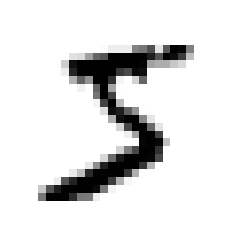

Target value:  5


In [3]:
' Observe the image represented in the first item of the data array'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

digit = X.to_numpy()[0].reshape(28,28)
plt.imshow(digit, cmap='binary')
plt.axis('off')
plt.show()
print('Target value: ', y.to_numpy()[0])

In [4]:
' Convert the labels from strings to integers'
import numpy as np
y = y.astype(np.uint8)
y.describe

<bound method NDFrame.describe of 0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8>

<b> By design the MNIST dataset is already split into a train and a test set.  The first 60,000 samples represent a shuffled training set and the remaining 10,000 are the test set. </b>

In [5]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

<b> Training a Binary Classifier </b>

In [6]:
' To begin, simplify the problem to identify only a single digit. 5 and not-5.'

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

 #### A quick note about the SGD classifer ###
    
The Stochastic Gradient Descent (SGD) classifer deals with training instances independently, one at a time. This makes it well suited for both online learning and very large datasets. It relies on randomness during training and for replicable results its important to set a random_state parameter

In [7]:
' Train a SGD classifer'
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([digit.flatten()])

array([ True])

<b> Evaluating a classifier is trickier than evaluating a regressor. As such a large section of this chapter will be devoted to methods used in evaluting classifiers </b>

#### Cross Validation

In [8]:
'''
    Sometimes you might want more control over the cross_validation process than what sklearn provides.  Understanding whats going on under the hood is important. 
    The following is an example of a loop which does roughly the same thing as sklearns cross_val_score() function
'''

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
# The StratifiedKFold class performs stratified sampling to produce folds that contain the representative ratio of each class.
# At each iteration the code creates a clone of the classifer, trains that clone on the training folds, then makes predictions on the test fold.
# Finally it displays the ratio of correct predictions as the final accuracy

0.9669
0.91625
0.96785


In [9]:
' Compare the manual cross validation loop with the results from sklearn cross_val_scoare'
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

<b> As always if the accuracy of the model seems to good to be true it likely is.  In this case the reason the accuracy is so high is that the composition of 5's in the dataset represent about 10% of the data.  As such, the model learns very quickkly that classifying everything as "not-5" yields very good results. This is a reason why accuracy is often not the preferred metric for classification performance, especially with skewed datasets where some values appear more often than others. </b>

In [10]:
' Compare the model results with that of a classifier which only returns False'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

#### Confusion Matrix

<b>Confustion matrices compare the predictions of a classifier into True Positives, True Negatives, False Positives, and  False Negatives. They are a much better tool for measuring a classifiers predictive ability than accuracy alone.</b>

In [11]:
' Construct a confustion matrix using sklearns cross_val_predict and confustion_matrix functions'
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs= -1)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

<b> The True values lie along the diagonal.  As with all square matrices the False values can be interpreted from the elements above or below the diagonal as their values will be symmetrical.</b>

<b> While the confusion matrix is a powerful tool and is superior than a simple accuracy score, a combination of <i> precision </i> and <i> recall </i> can provide a more concise metric for measuring the performance of the classifier </b>

#### Precision and Recall

$$ Precision = \frac{True Positives}{(True Positives + False Positives)} $$

$$ Recall = \frac{True Positives}{(True Positives + False Negatives)} $$

In [12]:
' Apply precision and recall to the binary classifier'
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print (precision, recall)

0.8370879772350012 0.6511713705958311


<b> This classifer predicts an image of a 5 correctly 83.7% of the time, and out of all of the 5s it only detects 65.1% of them. Having very high values of precision and recall is very difficult in practice and often you need to choose which one is more important for your application.  A useful metric for comparing predicitve power of various classifiers is the $F_{1}$ score.  The $F_{1}$ score favors classifiers with similar precision and recall and as mentioned before that isn't always what you want. </b>

$$ F_{1} = \frac{True Positives}{True Positives + \frac{(False Negatives + False Positives)}{2}} $$

In [13]:
' Apply the F1 score to the binary classifier'
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision / Recall Trade-off